# Run the block to import libraries by pressing Shift and Enter at the same time.

In [57]:
import pandas as pd



import trueskill as ts
import matplotlib.pyplot as plt
from collections import Counter
import requests
import io
import csv
%matplotlib inline
import seaborn as sns


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600
mpl.rcParams.update({'axes.titlesize': 'large'})
mpl.rcParams.update({'axes.labelsize': 'large'})

In [58]:
winner_cols = ['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']
loser_cols = ['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']

player_cols = winner_cols + loser_cols
relevant_cols = ['Map', 'Date', 'Score', 'Team'] + winner_cols + loser_cols

# No need to run anything from here until the next bolded section.

In [59]:
form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)
region = 'AUS'

In [60]:


form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)
form_df = form_df[form_df['Region'] == region]

loser_df = form_df['Losing players'].str.split(',|:', expand=True)
loser_df.columns = loser_cols
loser_df

winner_df = form_df['Winning players'].str.split(',|:', expand=True)
winner_df.columns = winner_cols

def Score(series):
    return (str(series['Winning Team Score']) + "-" + str(series['Losing Team Score']))
form_df['Score'] = form_df.apply(Score, axis = 1)
form_df.rename(columns={'Winning team': 'Team'}, inplace = True)
players_df = pd.concat([winner_df, loser_df], axis = 1)
form_df = pd.concat([form_df, players_df], axis = 1)
form_df['Date'] = form_df['Date'].apply(pd.to_datetime)

form_df[player_cols] = form_df[player_cols].apply(lambda x: x.str.strip())

if region == 'AUS':
    df = pd.read_excel("cb_jester_results.xlsx")
    bittah_tourny_df = pd.read_excel("bittah_5s_july.xlsx")
    bhp_df = pd.read_excel("Midair Games.xlsx", sheet_name = 'Sheet2')
    df = pd.concat([df, bittah_tourny_df, bhp_df, form_df[relevant_cols]], axis = 0, sort = False)
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower().str.strip())
    df.replace({'petgen': 'petty', 'base-head-panda|basehead':'bhp', 'rr': 'devik', 'hobb': 'nasty hobbit', 'xu1':'xui', 'colonel blair|colonelblair':'cb', \
                'rulefuckdoseplease':'kroz', 'kust0m': 'kustom', 'nextgen':'nexgen', 'phenom': 'mavi', 'raging moose': 'raging', 'tektra':'tekra', 'launchair':'laun', 'ultralpb': 'damo', \
                'gryp|style|bakara|air|nmag|dodge|mikehunt|spacecake': 'new'}, regex = True, inplace = True)
    player_dict = ['nasty hobbit', 'cyrus', 'ringo', 'neo', 'moose', 'chem', 'rumble', 'kroz', 'laun']
    
if region == 'NA':
    tea_df = pd.read_excel("tea_games.xlsx")
    tea_df['source'] = 'tea'
    sharp_df = pd.read_excel("Midair Games.xlsx")[tea_df.columns[:-1]]
    sharp_df['source'] = 'sharp|misc'
    byo5_df = pd.read_excel("byo5.xlsx")
    byo5_df['source'] = 'jp|byo5'
    stork_jp_df = pd.read_excel("stork_jp_stats.xlsx")
    stork_jp_df['source'] = 'stork|jp'
    yami_df = pd.read_excel("yami_moth.xlsx")
    yami_df['source'] = 'yami'
    lockjaw_fyr_df = pd.read_excel("lockjaw_fyr.xlsx")
    lockjaw_fyr_df['source'] = 'lockjaw|fyr'
    twitch_df = pd.read_excel("twitch_df.xlsx")
    twitch_df['source'] = twitch_df['Link']
    form_df['source'] = form_df['Submitter']

    df = pd.concat([tea_df, sharp_df, stork_jp_df, yami_df, byo5_df, lockjaw_fyr_df, twitch_df], axis = 0, sort = False)
    df = pd.concat([df, form_df], axis = 0, sort = False).copy()
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower())

    player_dict = ['stork', 'spark', 'scar', 'iced', 'b3d', 'bed', 'pika', 'icehawk', 'debug', 'joe', \
               'implo', 'dae', 'jon osc', 'skip', 'ringo', 'sharp', 'ramses', 'jimmy', 'yods', 'chem', \
               'lock', 'void', 'mista', 'anarchy', 'tyler', 'water', 'moose', 'name', 'tree', 'laun']

for player in player_dict:
    df[player_cols] = df[player_cols].replace({'(.*)' + player + '(.*)': player}, regex = True)

df[player_cols] = df[player_cols].replace({'couch' : 'boris', '^wb$': 'water', 'synergizer bunny': 'melur', 'dæ':'dae', 'debugxyz': 'debug', 'b3d':'bed', 'cargo': 'esprit', 'pissface': 'giohm', 'jon osc|jonosc': 'immie', \
             'v23': 'v22', 'jl': 'mal', 'a god damn demon': 'descolada', 'patrick': 'dae', 'pat': 'moose', 'shreq': 'schreq', 'doughboy': 'missb', \
           'bootswfur|bootswthefur|jeremy blime|apollyon|tumi|savior|smokin|xclusive|dust|app|mindflayr|cp|zeerat|\]\[ce|pancakemix|xan|yadig|sad|duck|ludang|total|sun dog|vitalica|galtath|joauva|loanwolf32|jeffreee|newb0|wristfracture|swoot|kevinator|intense|kromatic|superfam|cykon|chocotaco|debug|sauon|jfw20|wrightrj|hasslehof|cohen|extcy|robbie|ramses|ramses0|mysterium|brotein|germy the syphilis|raybidet|arrow|missd|mcnibbles|riley|pancak3s|bro\.scrubamtiskaw': 'newb', \
           'efx|krayvok|blakk|fire|zwidow|bugspray|apsteadyhands|bossdogxxx|ywontudie|phix|binladen|ucan|brooky|devil|proj|nof|ragencajuin|rosco|shrimm': 'decent'}, regex = True)



In [61]:
df.to_pickle(region + '_combined_midair_games.p')

# Read in Data
Choose your region in the cell below. Then, run everything from here to the bottom by pressing Shift + Enter multiple times. Pay attention to the "profile_player" function

In [73]:
region = 'AUS' # change this to NA or AUS for whichever region you want
df = pd.read_pickle(region + '_combined_midair_games.p')


In [74]:
def str_winning_team(series):
    return str(sorted(series[winner_cols]))
df['str_winning_team'] = df.apply(str_winning_team, axis = 1)


def str_losing_team(series):
    return str(sorted(series[loser_cols]))
df['str_losing_team'] = df.apply(str_losing_team, axis = 1)

df['Date'] = df['Date'].apply(pd.to_datetime)
df['Month'] = df['Date'].dt.month

df.drop_duplicates(subset = ['Month', 'Map', 'Team', 'str_winning_team', 'str_losing_team'], inplace = True)

df[player_cols] = df[player_cols].applymap(str)



df = df.sort_values(by = 'Date', ascending = True)

df['Map'] = df['Map'].str.lower()

# Create TrueSkill Rankings

In [75]:
df['Map'].value_counts()

elite          43
brynhildr      29
kryosis        29
minora         25
outpost        13
ingonyama      13
hypothermia    11
iguana         10
exhumed         6
nightflare      2
Name: Map, dtype: int64

In [76]:
players = list(set([item for sublist in df[player_cols].values.tolist() for item in sublist]))
players_ts = dict(zip(players, [ts.Rating() for i in players]))
players_ts_time = {player: [] for player in players}


def rankings(df, penalty):
    for i, row in df.iterrows():
    # Find ratings in dictionary
        winner_list = list(filter(None, list(row[winner_cols])))
        loser_list = list(filter(None, list(row[loser_cols])))
        t1 = [players_ts[player] for player in winner_list]
        t2 = [players_ts[player] for player in loser_list]
    # Get ratings after match
        a, b = (ts.rate([t1, t2], ranks=[0, 1]))
    #print (a,b)
        if row['Team'] == 'Tie':
            a, b = (ts.rate([t1, t2], ranks=[0, 0]))
        # Update ratings in dictionary (not necessary to split winners and losers, but easier to read and debug)
        for i, player in list(enumerate(winner_list)):
            players_ts[player] = a[i]
            players_ts_time[player].append(a[i].mu)
        for i, player in list(enumerate(loser_list)):
            players_ts[player] = b[i]
            players_ts_time[player].append(b[i].mu)
    
    sorted_rating_list = sorted(((value.mu, key) for (key,value) in players_ts.items()), reverse = True)
    rating_sigma_list = sorted(((round(value.mu, 1), round(value.sigma, 1), key) for (key,value) in players_ts.items()), reverse = True)
    adj_rating_list = sorted([(round((item[0] - penalty*item[1]),2), item[0], item[1], item[2]) for item in rating_sigma_list], reverse = True)

    tuple_df = pd.DataFrame(adj_rating_list, columns=['adj_rating', 'rating', 'uncertainty', 'name'])
    record_df = pd.DataFrame([(item[1], df[winner_cols].isin([item[1]]).any(axis = 1).sum(), df[loser_cols].isin([item[1]]).any(axis = 1).sum(), round(df[winner_cols].isin([item[1]]).any(axis = 1).sum()/df[loser_cols].isin([item[1]]).any(axis = 1).sum(), 1)) for item in sorted_rating_list], columns = ['name', 'wins', 'losses', 'ratio'])


    overall_rating_df = pd.merge(tuple_df, record_df, on = 'name', how = 'left')[['name', 'wins', 'losses', 'ratio', 'rating', 'uncertainty', 'adj_rating']]
    overall_rating_df['ratio'] = overall_rating_df['ratio'].apply(lambda x: round(x, 1))
    return overall_rating_df
rankings_df = rankings(df, penalty = 2)

/Users/francisloh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in long_scalars


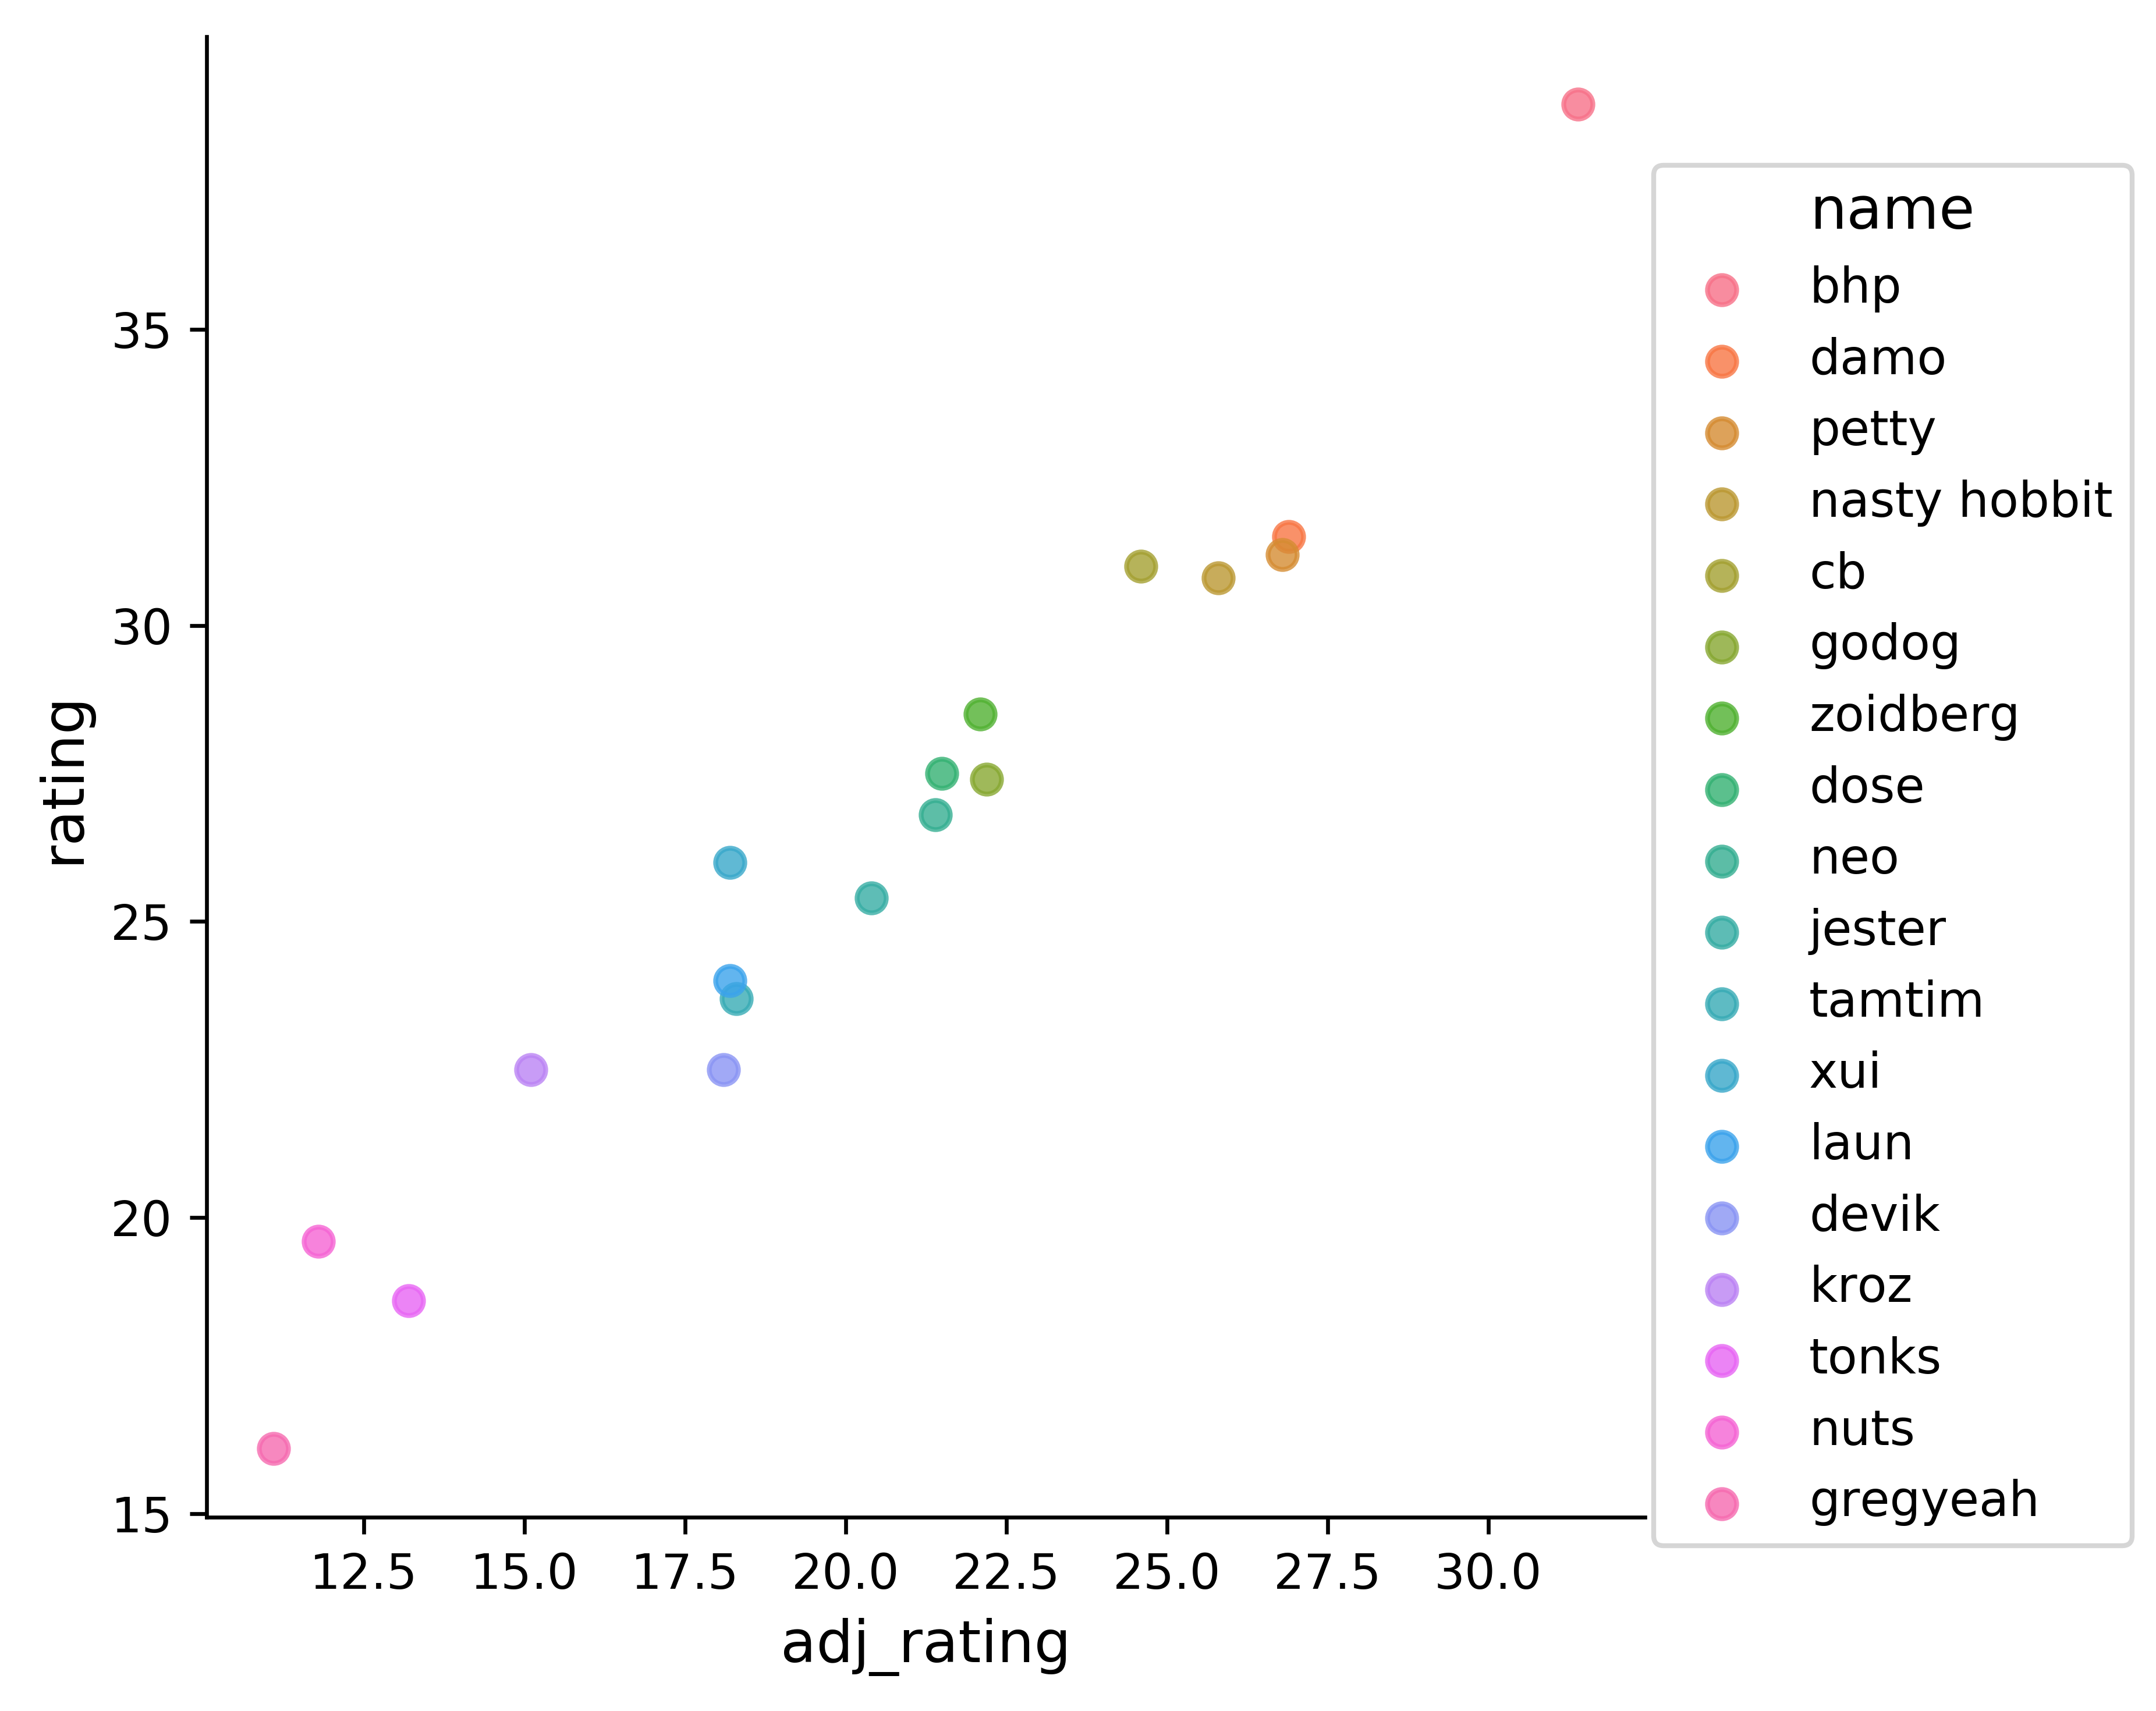

In [77]:
more_games_df = rankings_df[(rankings_df['wins'] + rankings_df['losses']) >= 35].reset_index(drop = True)
sns.lmplot(data=more_games_df, x="adj_rating",  y="rating", hue="name", fit_reg=False)

# Ratings
There are a lot of choices for rating systems. Popular rating systems include elo, glicko2, and trueskill. I opted to use TrueSkill since it's the only one that handles greater than 1v1 cases.

Mu represents the estimate of the true rating of a player. Sigma represents the uncertainty factor regarding the estimate of mu. This is often just as important. A player who won 3 out of 3 games but should have only won 2 out of 3 would have a high mu but would still retain a high sigma (low sigma). The algorithm takes into account whether the teams are stacked by calculating its own estimation of what the outcome of the match should be, based on the initial ratings of the players coming into the match.

Additional details can be found here: [Layman explanation](https://wiki.faforever.com/index.php?title=How_Trueskill_works), [Technical Explanation](https://www.moserware.com/assets/computing-your-skill/The%20Math%20Behind%20TrueSkill.pdf).

#### Players sorted by unadjusted TrueSkill rating (ie. no correction for sigma aka uncertainty)

In [78]:

sorted_rating_list = sorted(((value.mu, key) for (key,value) in players_ts.items()), reverse = True)
sorted_rating_list

[(38.826629846555655, 'bhp'),
 (35.334619659383314, 'moose'),
 (31.902372755903755, 'rain'),
 (31.480456492081984, 'damo'),
 (31.226853254764958, 'petty'),
 (31.033900892926525, 'cb'),
 (31.00981802973586, 'kustom'),
 (30.817923321767456, 'nasty hobbit'),
 (30.547841944639988, 'fyr'),
 (29.58020759235522, 'sickfest'),
 (28.659223104007392, 'chem'),
 (28.547723286585132, 'zoidberg'),
 (28.152274510985986, 'pyre'),
 (27.859527387784347, 'tyler'),
 (27.784334472640708, 'frostbite'),
 (27.45646680651969, 'dose'),
 (27.43257548710306, 'godog'),
 (27.224012632630554, 'confusion'),
 (27.04043531202623, 'manlover'),
 (26.844357362859256, 'raging'),
 (26.842499951082758, 'neo'),
 (26.698121713027742, 'nonreg'),
 (26.309508390481376, 'newbdrax'),
 (26.051285236543105, 'sajent'),
 (25.95023941468771, 'xui'),
 (25.847396128439122, 'danger'),
 (25.665296445921204, 'cantara'),
 (25.445709400691307, 'jester'),
 (24.94630412294208, 'nexgen'),
 (24.79310774708353, 'tea'),
 (24.70816530437286, 'tekra'),

#### Players sorted by TrueSkill adjusted rating, with add'l vals of mu and sigma

In [79]:
rating_sigma_list = sorted(((round(value.mu, 1), round(value.sigma, 1), key) for (key,value) in players_ts.items()), reverse = True)
adj_rating_list = sorted([(round((item[0] - 2*item[1]),2), item[0], item[1], item[2]) for item in rating_sigma_list], reverse = True)
tuple_df = pd.DataFrame(adj_rating_list, columns=['adj_rating', 'rating', 'uncertainty', 'name'])
record_df = pd.DataFrame([(item[1], df[winner_cols].isin([item[1]]).any(axis = 1).sum(), df[loser_cols].isin([item[1]]).any(axis = 1).sum(), round(df[winner_cols].isin([item[1]]).any(axis = 1).sum()/df[loser_cols].isin([item[1]]).any(axis = 1).sum(), 1)) for item in sorted_rating_list], columns = ['name', 'wins', 'losses', 'ratio'])
overall_rating_df = pd.merge(tuple_df, record_df, on = 'name', how = 'left')[['name', 'wins', 'losses', 'ratio', 'rating', 'uncertainty', 'adj_rating']]
overall_rating_df['ratio'] = overall_rating_df['ratio'].apply(lambda x: round(x, 1))
overall_rating_df[(overall_rating_df['wins'] + overall_rating_df['losses']) > 6].reset_index(drop = True)

/Users/francisloh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


,name,wins,losses,ratio,rating,uncertainty,adj_rating
0,bhp,28,10,2.8,38.8,3.7,31.4
1,damo,83,47,1.8,31.5,2.3,26.9
2,petty,61,67,0.9,31.2,2.2,26.8
3,moose,11,9,1.2,35.3,4.6,26.1
4,nasty hobbit,51,52,1.0,30.8,2.5,25.8
5,cb,38,20,1.9,31.0,3.2,24.6
6,kustom,15,19,0.8,31.0,3.6,23.8
7,godog,37,40,0.9,27.4,2.6,22.2
8,zoidberg,33,18,1.8,28.5,3.2,22.1
9,dose,38,31,1.2,27.5,3.0,21.5


#### Records for players sorted by rank

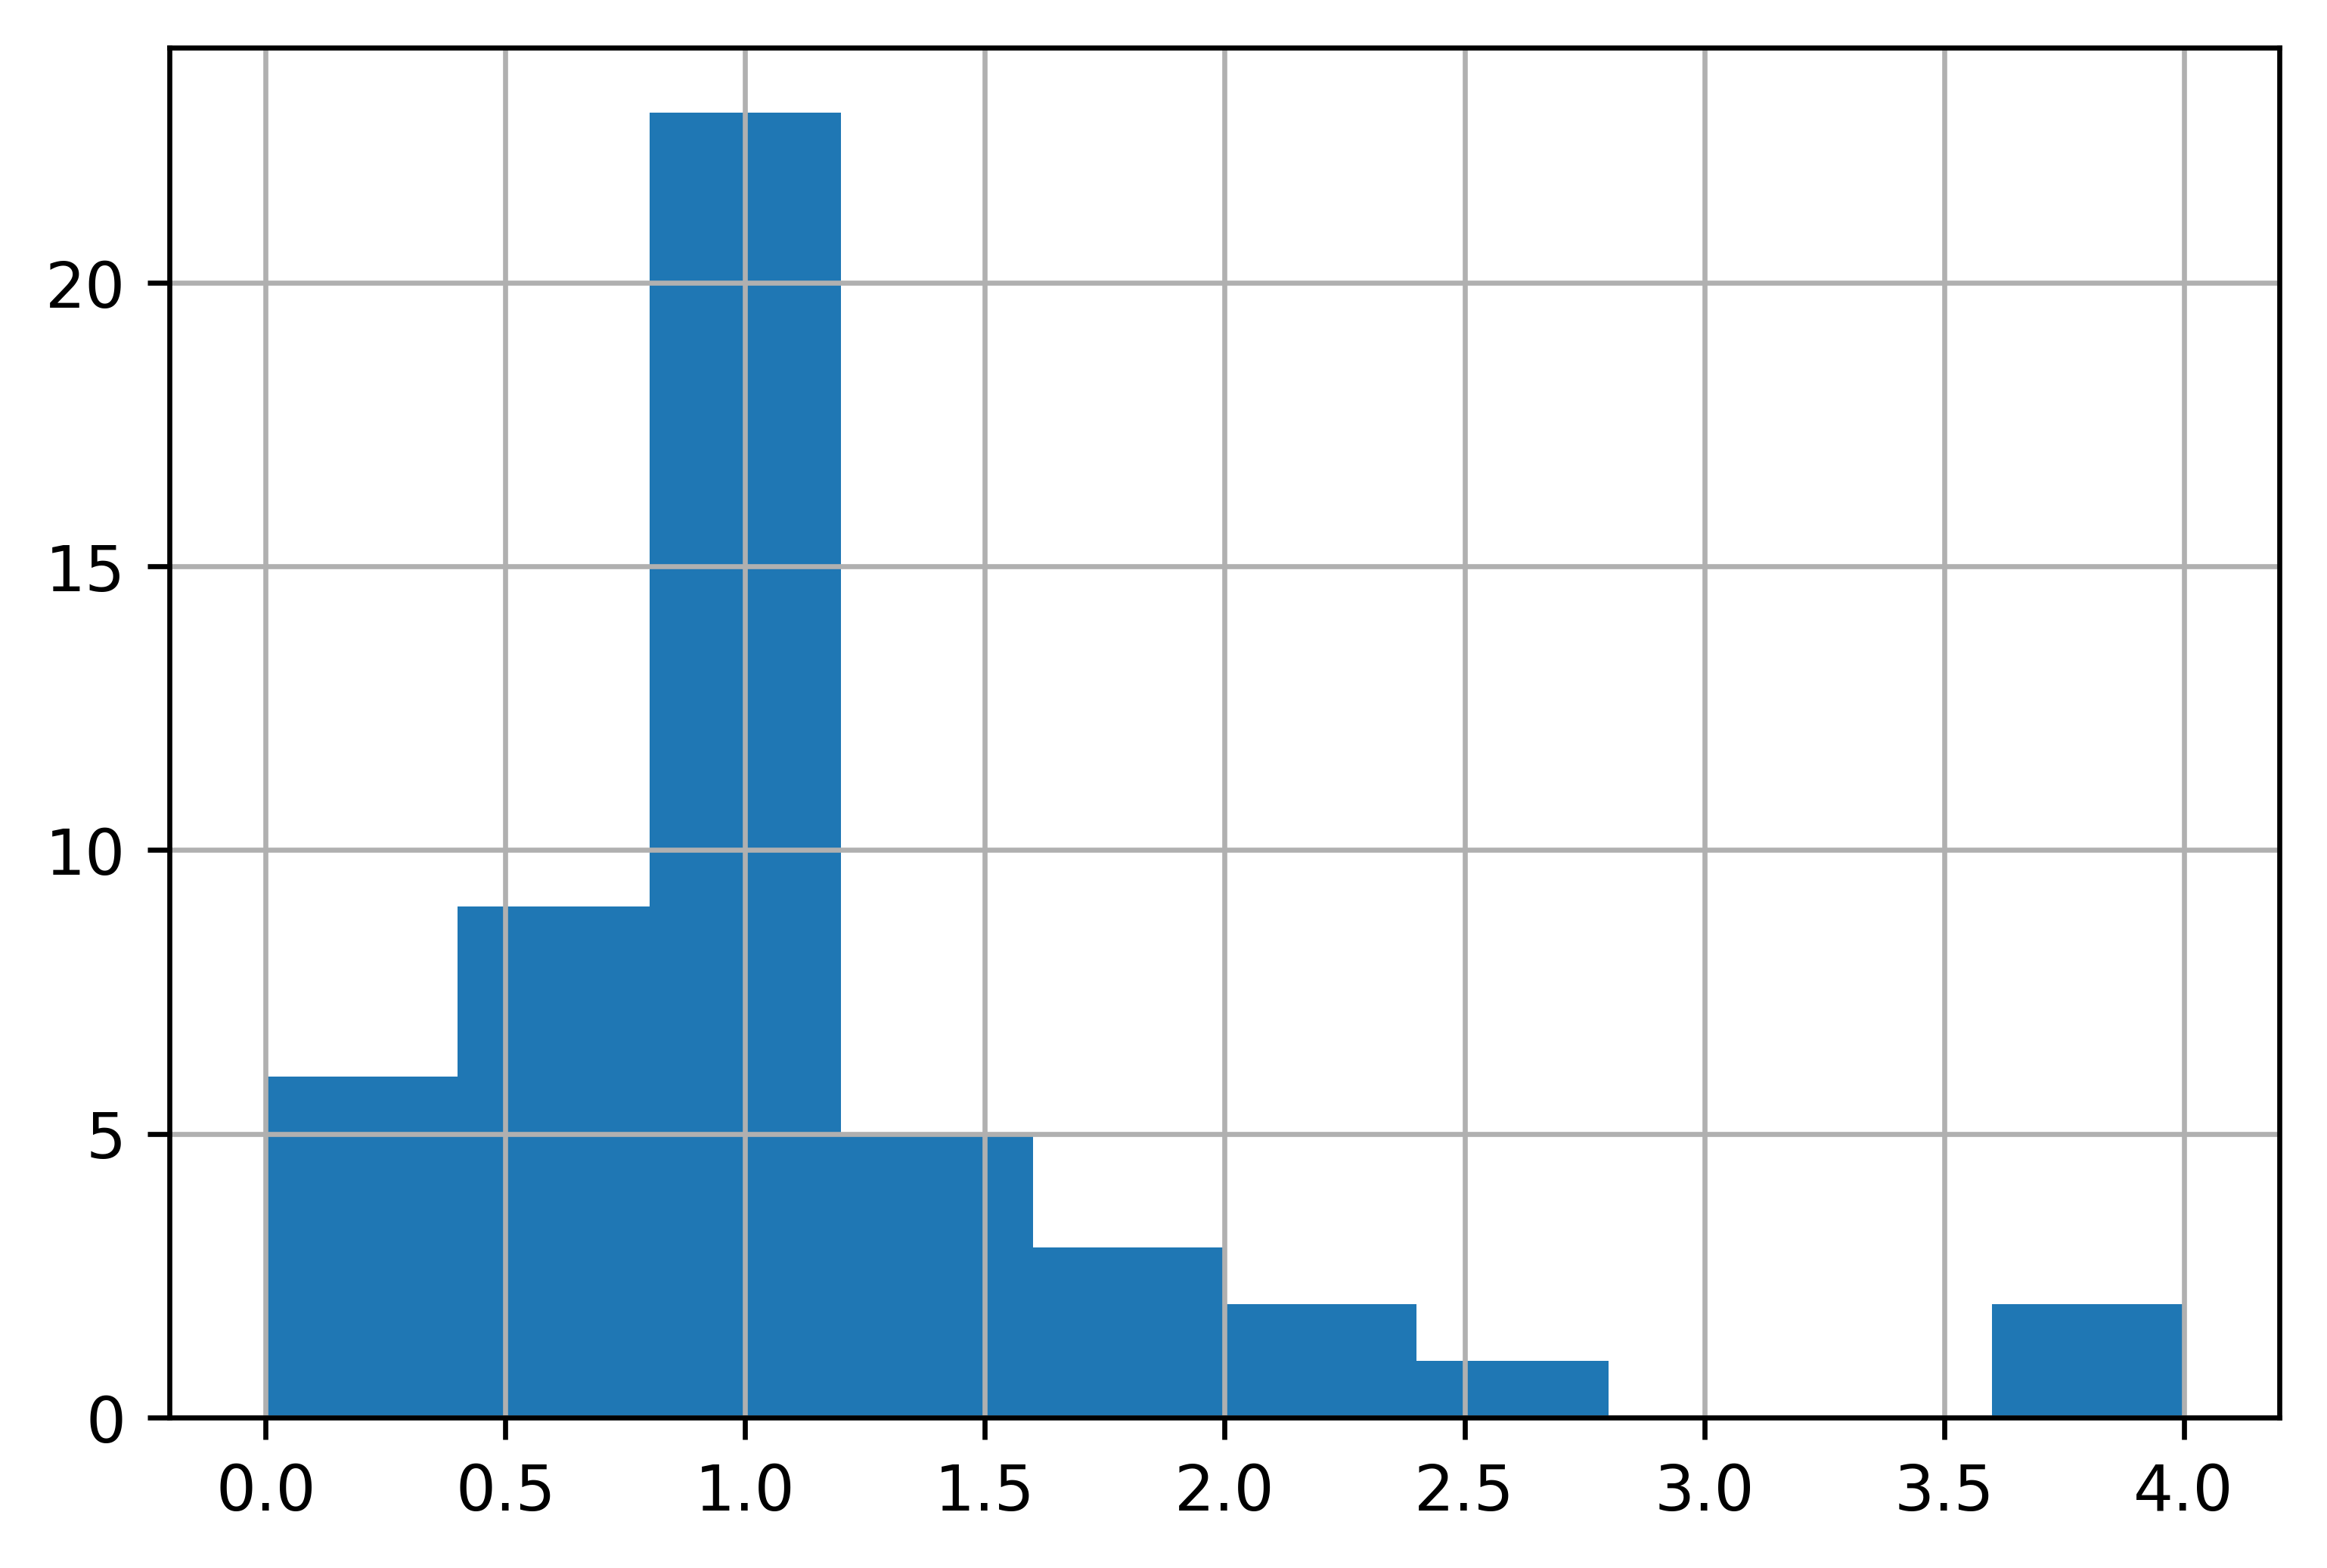

In [80]:
import numpy as np
overall_rating_df.replace([np.inf, -np.inf], np.nan).dropna(subset = ['ratio'], how = 'all')['ratio'].hist()

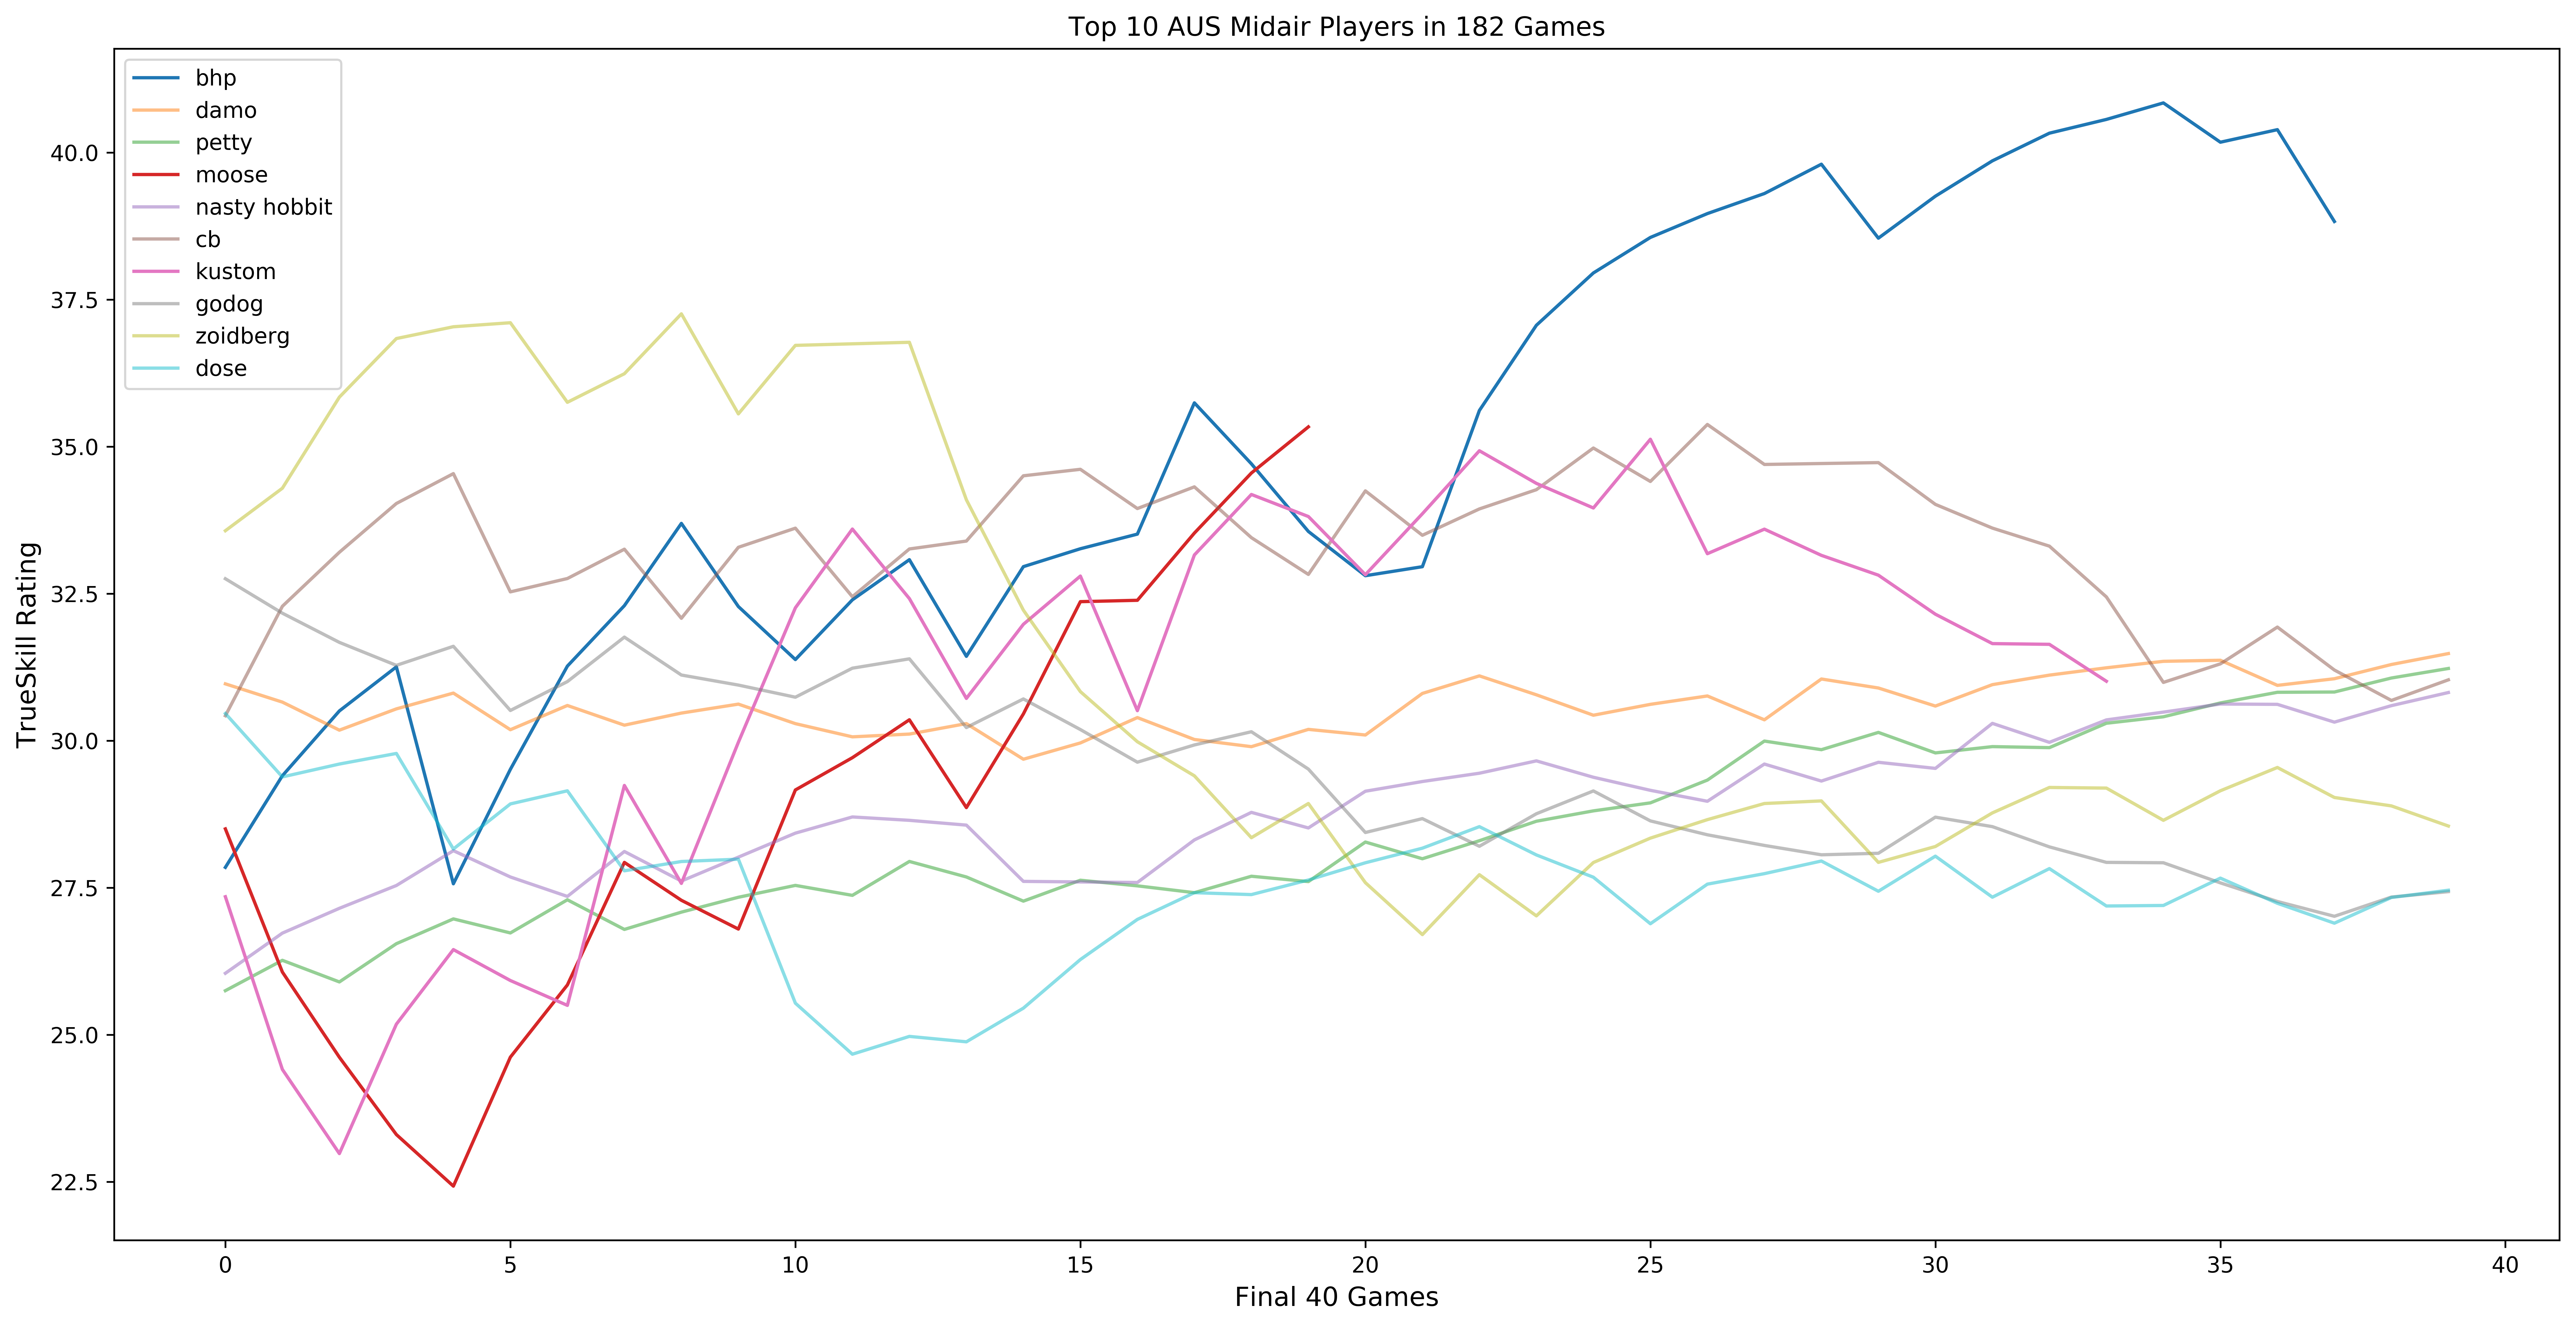

In [91]:

plotted_players = [item[1] for item in sorted_rating_list[0:10]]
plotted_players = [item[3] for item in adj_rating_list[0:10]]
#plotted_players = [k for (k,v) in players_ts_time.items() if ((len(v) > 125) & (len(v) > 125))]
plt.figure(figsize=(20,10))

final_games = 40
for i, player in enumerate(plotted_players):
    length = len(players_ts_time[player])
    if length > final_games:
        plt.plot(players_ts_time[player][(final_games*-1):], alpha=0.5)
    else:
        plt.plot(players_ts_time[player])
    
plt.title("Top " + str(len(plotted_players)) + ' ' +  str(region) + " Midair Players in " + str(df.shape[0]) + ' Games')
plt.xlabel('Final ' + str(final_games) + ' Games')
plt.ylabel('TrueSkill Rating')
plt.legend(plotted_players, loc = 'upper left')
plt.show()

In [82]:
def profile_player(target, partner_list = False, partner = False, opponent_list = False, opponent = False):
    profile_df = df[df[player_cols].isin([target]).any(axis = 1)]
    profile_df
    print (target + "'s record is: " + str(df[winner_cols].isin([target]).any(axis = 1).sum()) + " - " + \
           str(df[loser_cols].isin([target]).any(axis = 1).sum()))
    
    rank_ts = [(i+1, item[0]) for i, item in enumerate(sorted_rating_list) if item[1] == target][0]
    print (target + ' is ranked ' + str(rank_ts[0]) + ' out of ' + str(len(sorted_rating_list)) + \
          ', with TrueSkill score of ' + str(round(rank_ts[1], 3)) + ' and uncertainty of ' + str(round(players_ts[target].sigma, 3)))
    record_df = pd.concat([df[df[winner_cols].isin([target]).any(axis = 1)]['Map'].value_counts(), df[df[loser_cols].isin([target]).any(axis = 1)]['Map'].value_counts()], axis = 1, sort = True)
    record_df.columns = ['Wins', 'Losses']
    record_df.fillna(0, inplace = True)
    record_df.Wins = record_df.Wins.astype(int)
    record_df.Losses = record_df.Losses.astype(int)
    print (record_df)
    
    winner_partners_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    loser_partners_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    
    if partner_list is not False:
        ds = [winner_partners_dict, loser_partners_dict]
        d = {}
        for k in winner_partners_dict:
            d[k] = tuple(d[k] for d in ds)
            
        for k in loser_partners_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing with these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))

    if partner is not False:
        print ('\n' + target + ' has ' + str(winner_partners_dict[partner]) + ' wins and ' + \
               str(loser_partners_dict[partner]) + ' losses with ' + partner)
        
    winner_vs_opponents_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    loser_vs_opponents_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    
    if opponent_list is not False:
        ds = [winner_vs_opponents_dict, loser_vs_opponents_dict]
        d = {}
        for k in winner_vs_opponents_dict:
            d[k] = tuple(d[k] for d in ds)
        for k in loser_vs_opponents_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing against these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))
        #print(sorted(d, key=lambda x: d[x], reverse=True))
        
    if opponent is not False:
        print ('\n' + target + ' has ' + str(winner_vs_opponents_dict[opponent]) + ' wins ' + \
               str(loser_vs_opponents_dict[opponent]) + ' losses against ' + opponent)


In [83]:
profile_player(target = 'dae', partner_list = True, partner = False, opponent_list = True, opponent = False)

dae's record is: 10 - 9
dae is ranked 35 out of 53, with TrueSkill score of 23.709 and uncertainty of 5.148
             Wins  Losses
brynhildr       3       3
elite           2       2
hypothermia     1       0
ingonyama       0       1
kryosis         1       3
minora          2       0
outpost         1       0

dae's record when playing with these players:
[('dae', (10, 9)), ('jester', (6, 1)), ('nuts', (4, 2)), ('cantara', (4, 1)), ('xui', (4, 0)), ('gregyeah', (3, 1)), ('neo', (3, 0)), ('damo', (2, 5)), ('kroz', (2, 4)), ('cb', (2, 1)), ('sajent', (2, 1)), ('dose', (2, 0)), ('newb', (2, 0)), ('godog', (1, 3)), ('petty', (1, 1)), ('chem', (1, 1)), ('kustom', (1, 1)), ('devik', (0, 2)), ('laun', (0, 2)), ('iced', (0, 2)), ('danger', (0, 2)), ('tamtim', (0, 2)), ('tonks', (0, 2)), ('new', (0, 1)), ('raging', (0, 1))]

dae's record when playing against these players:
[('damo', (5, 3)), ('laun', (4, 2)), ('bloby', (4, 1)), ('cb', (3, 4)), ('gregyeah', (3, 2)), ('nuts', (3, 1)), ('pett

In [84]:
import itertools
import math
BETA = 4.1666
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    trueskill = ts.global_env()
    return round(trueskill.cdf(delta_mu / denom), 2)

def win_prob(series):
    return win_probability([players_ts[series['WPlayer1']], players_ts[series['WPlayer2']], players_ts[series['WPlayer3']], \
                     players_ts[series['WPlayer4']], players_ts[series['WPlayer5']]], \
                    [players_ts[series['LPlayer1']], players_ts[series['LPlayer2']], players_ts[series['LPlayer3']], \
                     players_ts[series['LPlayer4']], players_ts[series['LPlayer5']]])

df['win_probability'] = df.apply(win_prob, axis = 1)

def correct_ts_prediction(series):
    return 'Yes' if series['win_probability'] > 0.5 else 'No'
df['correct_ts_prediction'] = df.apply(correct_ts_prediction, axis = 1)

In [85]:
df[df['Team'] != 'Tie']['correct_ts_prediction'].value_counts()

Yes    136
No      39
Name: correct_ts_prediction, dtype: int64

In [86]:
win_probability([players_ts['slush'], players_ts['stork'], players_ts['icehawk'], players_ts['moose'], players_ts['joe']],\
                [players_ts['implo'], players_ts['rtcll'], players_ts['berserker'], players_ts['logic'], players_ts['sin']])

KeyError: 'slush'

In [90]:
df[df[player_cols].isin(['dose']).any(axis = 1)][['Map', 'Score', 'Month'] + ['str_winning_team', 'str_losing_team', 'win_probability']]

,Map,Score,Month,str_winning_team,str_losing_team,win_probability
31,kryosis,6-6,6.0,"['cb', 'damo', 'dose', 'nasty hobbit', 'zoidbe...","['godog', 'gregyeah', 'petty', 'skewa', 'xui']",0.98
30,ingonyama,8-0,6.0,"['cb', 'damo', 'dose', 'nasty hobbit', 'zoidbe...","['godog', 'gregyeah', 'petty', 'skewa', 'xui']",0.98
29,elite,8-7,6.0,"['cb', 'damo', 'dose', 'nasty hobbit', 'zoidbe...","['godog', 'gregyeah', 'petty', 'skewa', 'xui']",0.98
27,kryosis,6-5,6.0,"['damo', 'jester', 'nexgen', 'nuts', 'petty']","['cb', 'devik', 'dose', 'gregyeah', 'kroz']",0.79
26,elite,8-7,6.0,"['cb', 'damo', 'devik', 'jester', 'laun']","['dose', 'gregyeah', 'kroz', 'nexgen', 'nuts']",0.93
52,minora,8-6,6.0,"['damo', 'devik', 'jester', 'laun', 'newb']","['dose', 'godog', 'gregyeah', 'petty', 'tonks']",0.57
19,hypothermia,8-6,6.0,"['cb', 'dose', 'jester', 'laun', 'nasty hobbit']","['damo', 'devik', 'neo', 'newb', 'tea']",0.77
16,outpost,8-6,6.0,"['bloby', 'damo', 'laun', 'nasty hobbit', 'newb']","['cb', 'dose', 'gregyeah', 'jester', 'neo']",0.58
18,minora,8-6,6.0,"['cb', 'damo', 'devik', 'nasty hobbit', 'petty']","['bloby', 'dose', 'jester', 'neo', 'nuts']",0.93
77,brynhildr,7-5,7.0,"['damo', 'jester', 'laun', 'neo', 'rumble']","['dose', 'gregyeah', 'kroz', 'newb', 'nuts']",0.82


In [ ]:
df[df[winner_cols].isin(['joe']).any(axis = 1) & (df['Team'] == 'Blue')][player_cols] #& df[player_cols].isin(['sharp']).any(axis = 1)]

In [ ]:
df[df[player_cols].isin(['jp']).any(axis = 1)][['Date'] + player_cols] #& df[player_cols].isin(['sharp']).any(axis = 1)]

In [ ]:
df[df[player_cols].isin(['sharp']).any(axis = 1)]['Team'].value_counts()

In [ ]:
df[df[loser_cols].isin(['dose']).any(axis = 1)][['Date', 'str_winning_team', 'str_losing_team', 'win_probability', 'Team']]

In [87]:
df.shape

(182, 22)

In [88]:
df.tail()

,Map,Date,Score,Team,WPlayer1,WPlayer2,WPlayer3,WPlayer4,WPlayer5,LPlayer1,...,LPlayer4,LPlayer5,Outcome,Position,Midairs,str_winning_team,str_losing_team,Month,win_probability,correct_ts_prediction
199,outpost,2018-09-05,8-4,Blue,nasty hobbit,moose,zoidberg,gregyeah,tonks,nuts,...,godog,vloodzy,NaN,NaN,NaN,"['gregyeah', 'moose', 'nasty hobbit', 'tonks',...","['devik', 'dose', 'godog', 'nuts', 'vloodzy']",9.0,0.74,Yes
200,elite,2018-09-05,5-4,Blue,nasty hobbit,moose,zoidberg,gregyeah,nuts,dose,...,vloodzy,tonks,NaN,NaN,NaN,"['gregyeah', 'moose', 'nasty hobbit', 'nuts', ...","['devik', 'dose', 'godog', 'tonks', 'vloodzy']",9.0,0.77,Yes
201,kryosis,2018-09-06,8-2,Red,godog,dose,mavi,pyre,nuts,kroz,...,seldom,vloodzy,NaN,NaN,NaN,"['dose', 'godog', 'mavi', 'nuts', 'pyre']","['cb', 'kroz', 'seldom', 'vloodzy', 'zoidberg']",9.0,0.69,Yes
202,elite,2018-09-06,8-2,Red,godog,dose,mavi,pyre,nuts,kroz,...,seldom,vloodzy,NaN,NaN,NaN,"['dose', 'godog', 'mavi', 'nuts', 'pyre']","['gregyeah', 'kroz', 'seldom', 'vloodzy', 'zoi...",9.0,0.90,Yes
117,outpost,NaT,8-5,Blue,neo,petty,cb,jester,new,zoidberg,...,devik,tamtim,NaN,NaN,NaN,"['cb', 'jester', 'neo', 'new', 'petty']","['devik', 'mavi', 'nexgen', 'tamtim', 'zoidberg']",NaN,0.77,Yes
